In [101]:
# @title CIFAR10 Classifier
import torch
import torch.nn as nn

class CIFAR10Classifier(nn.Module):
    def __init__(self):
        super(CIFAR10Classifier, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),  # Вхідні канали: 3, Вихідні: 32
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2, 2),  # Зменшення розміру на 2

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2, 2),
        )
        self.fc_layers = nn.Sequential(
            nn.Linear(128 * 4 * 4, 256),  # 4*4 - після трьох шарів MaxPool
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 10)  # 10 класів
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)  # Розгортання
        x = self.fc_layers(x)
        return x

net = CIFAR10Classifier()
print(net)


CIFAR10Classifier(
  (conv_layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_layers): Sequential(
    (0): Linear(in_features=2048, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3):

Files already downloaded and verified
Files already downloaded and verified


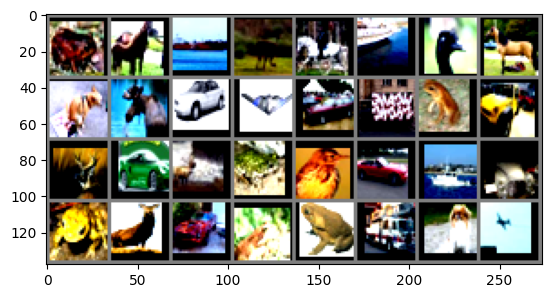

frog horse ship bird horse ship bird horse


In [102]:
# @title Datasets
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np

transforms_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])
transforms_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])


train_dataset = torchvision.datasets.CIFAR10(root="./data", train=True, download=True, transform=transforms_train)
test_dataset = torchvision.datasets.CIFAR10(root="./data", train=False, download=True, transform=transforms_test)

train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=8)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=8)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=8)

classes = train_dataset.dataset.classes

def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(train_loader)
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images))
print(" ".join(f"{classes[labels[j]]}" for j in range(8)))


In [97]:
# @title Early Stopping
import numpy as np
import torch

class EarlyStopping:
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pth', trace_func=print):
        self.patience = patience
        self.verbose = verbose
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f"EarlyStopping counter: {self.counter} out of {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            self.trace_func(f"Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}). Saving model ...")
        # torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss


In [103]:
# @title Train Model
from tqdm import tqdm

def train_model(net, device, train_loader, val_loader, optimizer, criterion, num_epochs=50, patience=4, path='best_model.pth'):
    print(device)

    net.to(device)

    train_losses, val_losses, train_accuracy, val_accuracy = [], [], [], []

    early_stopping = EarlyStopping(patience=patience, verbose=True, path=path)

    for epoch in range(num_epochs):
        net.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0

        for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()

        train_losses.append(train_loss / len(train_loader))
        train_accuracy.append(100 * train_correct / train_total)

        net.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = net(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        val_losses.append(val_loss / len(val_loader))
        val_accuracy.append(100 * val_correct / val_total)
        print(f"Train Accuracy: {train_accuracy[-1]:.2f}%")
        print(f"Validation Accuracy: {val_accuracy[-1]:.2f}%")
        print(f"Epoch {epoch+1}: Train Loss = {train_losses[-1]:.4f}, Val Loss = {val_losses[-1]:.4f}")

        early_stopping(val_losses[-1], net)

        if early_stopping.early_stop:
            print("Early stopping")
            break

    torch.save(net.state_dict(), path)

    return train_losses, val_losses, train_accuracy, val_accuracy


In [104]:
# @title Train Script
import torch.optim as optim
from torch.optim.lr_scheduler import OneCycleLR

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net = net.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-5)

train_losses, val_losses, train_accuracy, val_accuracy = train_model(
    net=net,
    device=device,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    criterion=criterion,
)

print(train_losses, val_losses)

cuda


Epoch 1/50: 100%|██████████| 1250/1250 [00:07<00:00, 176.46it/s]


Train Accuracy: 35.15%
Validation Accuracy: 47.53%
Epoch 1: Train Loss = 1.8006, Val Loss = 1.4323
Validation loss decreased (inf --> 1.432293). Saving model ...


Epoch 2/50: 100%|██████████| 1250/1250 [00:07<00:00, 164.51it/s]


Train Accuracy: 48.57%
Validation Accuracy: 58.52%
Epoch 2: Train Loss = 1.4597, Val Loss = 1.1644
Validation loss decreased (1.432293 --> 1.164375). Saving model ...


Epoch 3/50: 100%|██████████| 1250/1250 [00:07<00:00, 171.49it/s]


Train Accuracy: 57.56%
Validation Accuracy: 63.20%
Epoch 3: Train Loss = 1.2156, Val Loss = 1.0206
Validation loss decreased (1.164375 --> 1.020608). Saving model ...


Epoch 4/50: 100%|██████████| 1250/1250 [00:07<00:00, 176.79it/s]


Train Accuracy: 63.12%
Validation Accuracy: 67.99%
Epoch 4: Train Loss = 1.0640, Val Loss = 0.9162
Validation loss decreased (1.020608 --> 0.916215). Saving model ...


Epoch 5/50: 100%|██████████| 1250/1250 [00:07<00:00, 176.36it/s]


Train Accuracy: 66.33%
Validation Accuracy: 68.37%
Epoch 5: Train Loss = 0.9681, Val Loss = 0.9024
Validation loss decreased (0.916215 --> 0.902392). Saving model ...


Epoch 6/50: 100%|██████████| 1250/1250 [00:07<00:00, 178.55it/s]


Train Accuracy: 68.17%
Validation Accuracy: 70.85%
Epoch 6: Train Loss = 0.9197, Val Loss = 0.8274
Validation loss decreased (0.902392 --> 0.827396). Saving model ...


Epoch 7/50: 100%|██████████| 1250/1250 [00:06<00:00, 178.68it/s]


Train Accuracy: 69.83%
Validation Accuracy: 70.77%
Epoch 7: Train Loss = 0.8767, Val Loss = 0.8478
EarlyStopping counter: 1 out of 4


Epoch 8/50: 100%|██████████| 1250/1250 [00:07<00:00, 173.82it/s]


Train Accuracy: 70.97%
Validation Accuracy: 73.32%
Epoch 8: Train Loss = 0.8442, Val Loss = 0.7755
Validation loss decreased (0.827396 --> 0.775538). Saving model ...


Epoch 9/50: 100%|██████████| 1250/1250 [00:07<00:00, 175.14it/s]


Train Accuracy: 71.90%
Validation Accuracy: 73.23%
Epoch 9: Train Loss = 0.8153, Val Loss = 0.7782
EarlyStopping counter: 1 out of 4


Epoch 10/50: 100%|██████████| 1250/1250 [00:07<00:00, 177.03it/s]


Train Accuracy: 72.83%
Validation Accuracy: 72.63%
Epoch 10: Train Loss = 0.7939, Val Loss = 0.7746
Validation loss decreased (0.775538 --> 0.774633). Saving model ...


Epoch 11/50: 100%|██████████| 1250/1250 [00:07<00:00, 174.38it/s]


Train Accuracy: 73.32%
Validation Accuracy: 74.95%
Epoch 11: Train Loss = 0.7753, Val Loss = 0.7294
Validation loss decreased (0.774633 --> 0.729356). Saving model ...


Epoch 12/50: 100%|██████████| 1250/1250 [00:07<00:00, 177.84it/s]


Train Accuracy: 73.76%
Validation Accuracy: 76.24%
Epoch 12: Train Loss = 0.7558, Val Loss = 0.6953
Validation loss decreased (0.729356 --> 0.695300). Saving model ...


Epoch 13/50: 100%|██████████| 1250/1250 [00:06<00:00, 178.90it/s]


Train Accuracy: 74.58%
Validation Accuracy: 76.12%
Epoch 13: Train Loss = 0.7408, Val Loss = 0.6964
EarlyStopping counter: 1 out of 4


Epoch 14/50: 100%|██████████| 1250/1250 [00:07<00:00, 171.57it/s]


Train Accuracy: 75.22%
Validation Accuracy: 76.74%
Epoch 14: Train Loss = 0.7174, Val Loss = 0.6874
Validation loss decreased (0.695300 --> 0.687423). Saving model ...


Epoch 15/50: 100%|██████████| 1250/1250 [00:07<00:00, 175.79it/s]


Train Accuracy: 75.66%
Validation Accuracy: 76.93%
Epoch 15: Train Loss = 0.7111, Val Loss = 0.6713
Validation loss decreased (0.687423 --> 0.671347). Saving model ...


Epoch 16/50: 100%|██████████| 1250/1250 [00:06<00:00, 182.79it/s]


Train Accuracy: 75.97%
Validation Accuracy: 76.95%
Epoch 16: Train Loss = 0.7016, Val Loss = 0.6659
Validation loss decreased (0.671347 --> 0.665940). Saving model ...


Epoch 17/50: 100%|██████████| 1250/1250 [00:07<00:00, 174.47it/s]


Train Accuracy: 76.28%
Validation Accuracy: 77.84%
Epoch 17: Train Loss = 0.6909, Val Loss = 0.6656
Validation loss decreased (0.665940 --> 0.665644). Saving model ...


Epoch 18/50: 100%|██████████| 1250/1250 [00:07<00:00, 178.20it/s]


Train Accuracy: 76.81%
Validation Accuracy: 78.60%
Epoch 18: Train Loss = 0.6750, Val Loss = 0.6318
Validation loss decreased (0.665644 --> 0.631774). Saving model ...


Epoch 19/50: 100%|██████████| 1250/1250 [00:06<00:00, 178.59it/s]


Train Accuracy: 77.18%
Validation Accuracy: 77.75%
Epoch 19: Train Loss = 0.6665, Val Loss = 0.6723
EarlyStopping counter: 1 out of 4


Epoch 20/50: 100%|██████████| 1250/1250 [00:07<00:00, 177.17it/s]


Train Accuracy: 77.54%
Validation Accuracy: 75.91%
Epoch 20: Train Loss = 0.6591, Val Loss = 0.7168
EarlyStopping counter: 2 out of 4


Epoch 21/50: 100%|██████████| 1250/1250 [00:07<00:00, 175.43it/s]


Train Accuracy: 77.62%
Validation Accuracy: 78.06%
Epoch 21: Train Loss = 0.6552, Val Loss = 0.6227
Validation loss decreased (0.631774 --> 0.622738). Saving model ...


Epoch 22/50: 100%|██████████| 1250/1250 [00:06<00:00, 181.71it/s]


Train Accuracy: 77.92%
Validation Accuracy: 78.80%
Epoch 22: Train Loss = 0.6421, Val Loss = 0.6059
Validation loss decreased (0.622738 --> 0.605918). Saving model ...


Epoch 23/50: 100%|██████████| 1250/1250 [00:07<00:00, 170.01it/s]


Train Accuracy: 78.01%
Validation Accuracy: 78.81%
Epoch 23: Train Loss = 0.6364, Val Loss = 0.6143
EarlyStopping counter: 1 out of 4


Epoch 24/50: 100%|██████████| 1250/1250 [00:07<00:00, 173.37it/s]


Train Accuracy: 78.43%
Validation Accuracy: 79.55%
Epoch 24: Train Loss = 0.6291, Val Loss = 0.6026
Validation loss decreased (0.605918 --> 0.602634). Saving model ...


Epoch 25/50: 100%|██████████| 1250/1250 [00:06<00:00, 179.60it/s]


Train Accuracy: 78.54%
Validation Accuracy: 79.37%
Epoch 25: Train Loss = 0.6236, Val Loss = 0.6063
EarlyStopping counter: 1 out of 4


Epoch 26/50: 100%|██████████| 1250/1250 [00:07<00:00, 173.14it/s]


Train Accuracy: 79.06%
Validation Accuracy: 79.42%
Epoch 26: Train Loss = 0.6107, Val Loss = 0.6207
EarlyStopping counter: 2 out of 4


Epoch 27/50: 100%|██████████| 1250/1250 [00:06<00:00, 183.64it/s]


Train Accuracy: 79.11%
Validation Accuracy: 78.38%
Epoch 27: Train Loss = 0.6064, Val Loss = 0.6377
EarlyStopping counter: 3 out of 4


Epoch 28/50: 100%|██████████| 1250/1250 [00:06<00:00, 179.00it/s]


Train Accuracy: 79.27%
Validation Accuracy: 79.60%
Epoch 28: Train Loss = 0.6027, Val Loss = 0.5954
Validation loss decreased (0.602634 --> 0.595449). Saving model ...


Epoch 29/50: 100%|██████████| 1250/1250 [00:07<00:00, 173.41it/s]


Train Accuracy: 79.67%
Validation Accuracy: 79.97%
Epoch 29: Train Loss = 0.5962, Val Loss = 0.6175
EarlyStopping counter: 1 out of 4


Epoch 30/50: 100%|██████████| 1250/1250 [00:07<00:00, 178.26it/s]


Train Accuracy: 79.98%
Validation Accuracy: 80.27%
Epoch 30: Train Loss = 0.5880, Val Loss = 0.5914
Validation loss decreased (0.595449 --> 0.591361). Saving model ...


Epoch 31/50: 100%|██████████| 1250/1250 [00:06<00:00, 179.72it/s]


Train Accuracy: 80.37%
Validation Accuracy: 80.56%
Epoch 31: Train Loss = 0.5833, Val Loss = 0.5896
Validation loss decreased (0.591361 --> 0.589577). Saving model ...


Epoch 32/50: 100%|██████████| 1250/1250 [00:07<00:00, 173.80it/s]


Train Accuracy: 80.17%
Validation Accuracy: 80.17%
Epoch 32: Train Loss = 0.5769, Val Loss = 0.5766
Validation loss decreased (0.589577 --> 0.576632). Saving model ...


Epoch 33/50: 100%|██████████| 1250/1250 [00:07<00:00, 170.65it/s]


Train Accuracy: 80.07%
Validation Accuracy: 80.69%
Epoch 33: Train Loss = 0.5783, Val Loss = 0.5706
Validation loss decreased (0.576632 --> 0.570560). Saving model ...


Epoch 34/50: 100%|██████████| 1250/1250 [00:07<00:00, 178.06it/s]


Train Accuracy: 80.44%
Validation Accuracy: 80.80%
Epoch 34: Train Loss = 0.5673, Val Loss = 0.5899
EarlyStopping counter: 1 out of 4


Epoch 35/50: 100%|██████████| 1250/1250 [00:06<00:00, 178.90it/s]


Train Accuracy: 80.74%
Validation Accuracy: 80.56%
Epoch 35: Train Loss = 0.5650, Val Loss = 0.5779
EarlyStopping counter: 2 out of 4


Epoch 36/50: 100%|██████████| 1250/1250 [00:06<00:00, 180.22it/s]


Train Accuracy: 80.91%
Validation Accuracy: 80.16%
Epoch 36: Train Loss = 0.5613, Val Loss = 0.6071
EarlyStopping counter: 3 out of 4


Epoch 37/50: 100%|██████████| 1250/1250 [00:07<00:00, 175.00it/s]


Train Accuracy: 80.73%
Validation Accuracy: 81.28%
Epoch 37: Train Loss = 0.5622, Val Loss = 0.5734
EarlyStopping counter: 4 out of 4
Early stopping
[1.8006317474365234, 1.4597219031333923, 1.2156292446613313, 1.0639990058660507, 0.9681069791078567, 0.919659975528717, 0.8767028680086136, 0.8441627421617508, 0.8152983134508133, 0.7938934570550918, 0.7753276411533355, 0.7558347140908241, 0.740839001584053, 0.7174460195183754, 0.71105804656744, 0.7015697115421295, 0.6908648599863052, 0.675042574095726, 0.6664985453367234, 0.6591187910795212, 0.6551841114759445, 0.6421417291641235, 0.6364329053163529, 0.6291284787416458, 0.6235629636645317, 0.6106895811796188, 0.6063509142994881, 0.602726403182745, 0.5962018222808838, 0.5880049101352691, 0.5833101834774017, 0.5768633192300796, 0.5783418763160706, 0.5672585870146751, 0.565021136879921, 0.5613039037168026, 0.5622232390642166] [1.432292705526748, 1.1643751619722897, 1.0206081690117954, 0.9162152626643927, 0.9023916614703096, 0.827396160021376

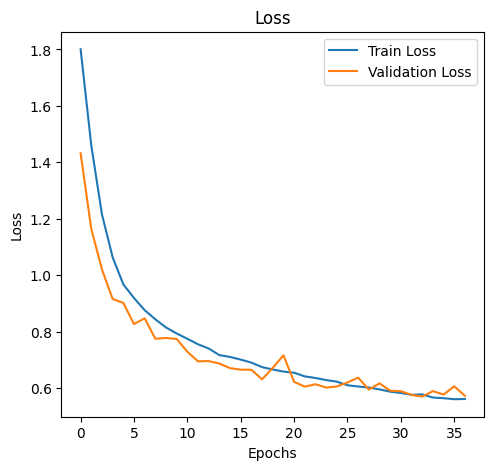

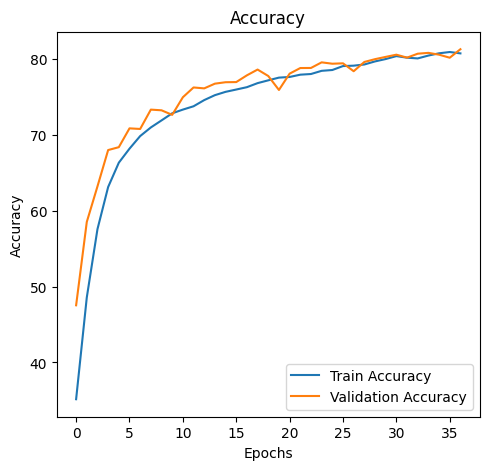

In [105]:
# @title Train diagram
# Графіки втрат
plt.figure(figsize=(12, 5))

# Графік втрат
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.title("Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()

plt.figure(figsize=(12, 5))

# Графік втрат
plt.subplot(1, 2, 1)
plt.plot(train_accuracy, label="Train Accuracy")
plt.plot(val_accuracy, label="Validation Accuracy")
plt.title("Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.show()


In [106]:
# @title Test script
import os
if os.path.exists("best_model.pth"):
    net.load_state_dict(torch.load("best_model.pth"))
else:
    print("Model file not found!")
    exit()

net.eval()
test_loss = 0.0
correct = 0
total = 0
num_classes = 10
class_correct = [0] * num_classes
class_total = [0] * num_classes

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = net(inputs)

        loss = criterion(outputs, labels)
        test_loss += loss.item() * inputs.size(0)

        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

        for i in range(labels.size(0)):
            label = labels[i]
            class_correct[label] += (predicted[i] == label).item()
            class_total[label] += 1

test_loss /= total
test_accuracy = 100 * correct / total
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

for i in range(num_classes):
    if class_total[i] > 0:
        print(f"Accuracy of class {i}: {100 * class_correct[i] / class_total[i]:.2f}%")
    else:
        print(f"Accuracy of class {i}: No samples")


<ipython-input-106-25f3318e4fa7>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load("best_model.pth"))


Test Loss: 0.5307, Test Accuracy: 83.09%
Accuracy of class 0: 83.60%
Accuracy of class 1: 93.80%
Accuracy of class 2: 72.70%
Accuracy of class 3: 66.60%
Accuracy of class 4: 84.30%
Accuracy of class 5: 74.30%
Accuracy of class 6: 90.30%
Accuracy of class 7: 86.40%
Accuracy of class 8: 89.90%
Accuracy of class 9: 89.00%
